In [2]:
# If using docker make sure that git is installed
!pip install git+https://github.com/JihongJu/keras-fcn.git -q
!pip install keras -q

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import pathlib, glob, re
import os
from PIL import Image
from tensorflow.keras.layers import Conv2D, Add, Conv2DTranspose, Activation

%pylab inline
tf.enable_eager_execution()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


In [2]:
ds_root = '/home/datasets/pascalvoc/VOCdevkit/VOC2012/'
images_path = ds_root + 'JPEGImages/'
train_set = ds_root + 'ImageSets/Segmentation/train.txt'
val_set = ds_root + 'ImageSets/Segmentation/val.txt'
labels_path =  ds_root + 'SegmentationClass/'

In [3]:
with open(train_set) as ts:
    train_image_names = ts.read().split()
with open(val_set) as ts:
    val_image_names = ts.read().split()

In [4]:
def load_and_preprocess_png(path):
    image = Image.open(path)
    image = np.array(image)
    # Do we want to classify background?
    image[image == 255.] = 0.
    image = tf.one_hot(image, 21)
    # Method 1 = nearest neighbour
    image = tf.image.resize_images(image, [256, 256], method=1)
    return image

def load_and_preprocess_jpg(path):
    path = tf.convert_to_tensor(path, dtype=tf.string)
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [256, 256])
    image /= tf.constant(255.0)
    return image

def load_and_preprocess(path, label_path):
    return load_and_preprocess_jpg(path), load_and_preprocess_png(label_path)

def dataset_generator():
    i = 0
    while True:
        i = (i+1) % len(train_paths)
        yield load_and_preprocess(train_paths[i], train_label_paths[i])        

In [5]:
def load_dataset(paths, labels):
    ds = tf.data.Dataset.from_generator(dataset_generator, output_types=(
        tf.float32, tf.float32))
    ds = ds.shuffle(buffer_size=32)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [6]:
train_paths = [images_path + name + '.jpg' for name in train_image_names]
train_label_paths = [labels_path + name + '.png' for name in train_image_names]
val_paths = [images_path + name + '.jpg' for name in val_image_names]
val_label_paths = [labels_path + name + '.png' for name in val_image_names]

In [7]:
BATCH_SIZE = 8
train_ds = load_dataset(train_paths, train_label_paths)
val_ds = load_dataset(val_paths, val_label_paths)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [15]:
data, target = iter(train_ds).next()

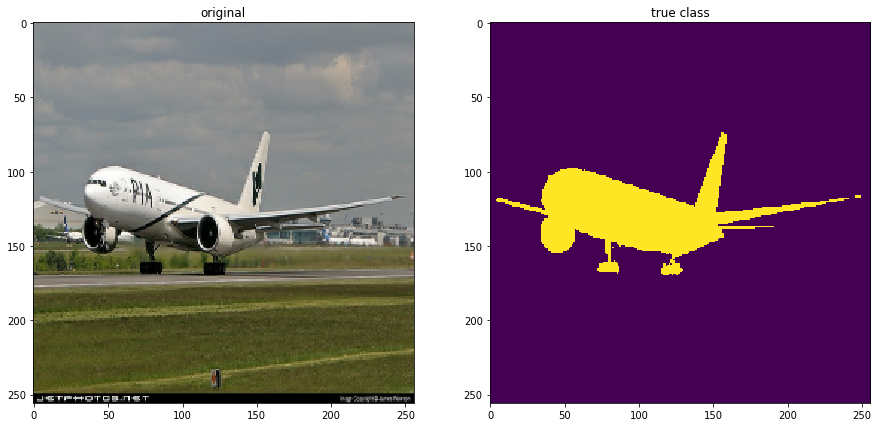

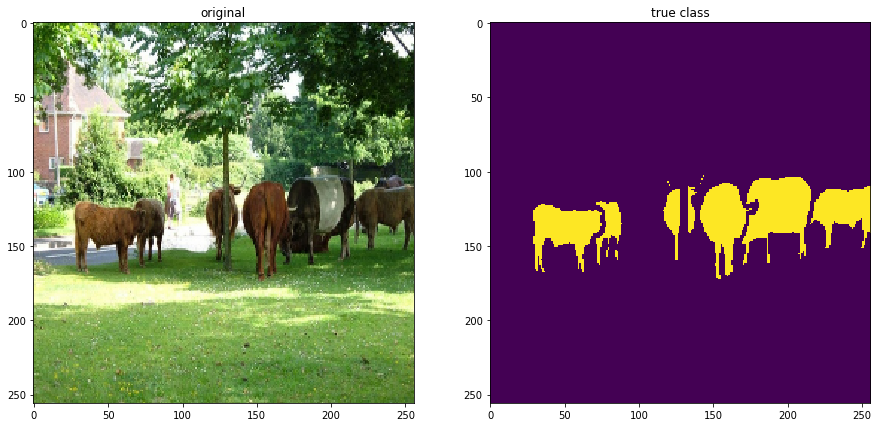

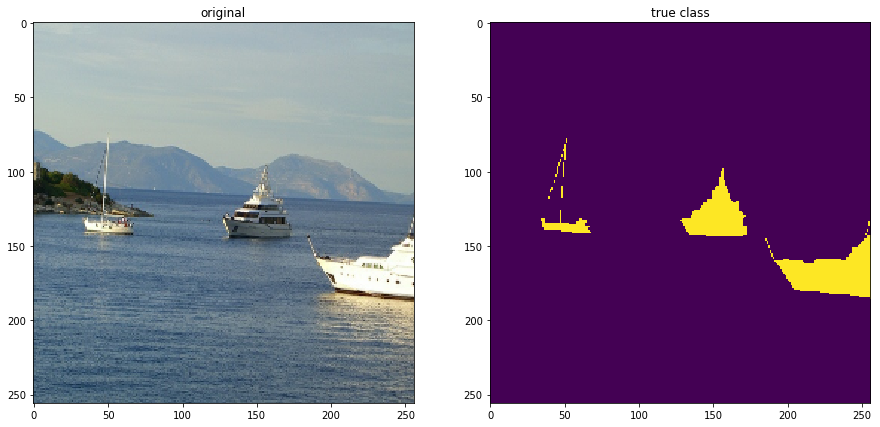

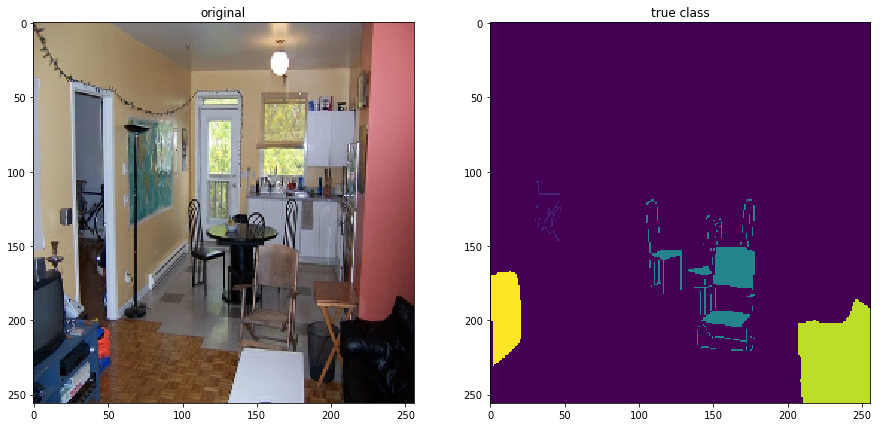

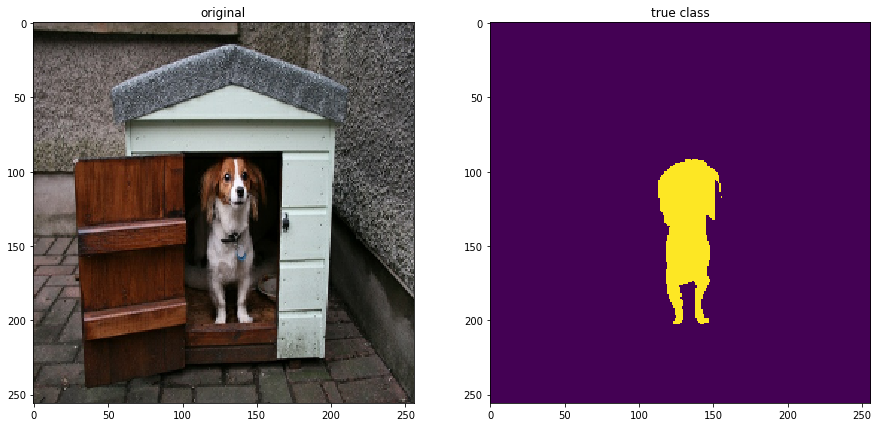

In [119]:
for i in range(5):
    fig = plt.figure(figsize=(15,30)) 
    ax = fig.add_subplot(1,2,1)
    ax.imshow(data[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(np.argmax(target[i], axis=2))
    ax.set_title("true class")
    
    plt.show()

In [17]:
base_vgg = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=False)

In [18]:
for layer in base_vgg.layers:
    layer.trainable = False

In [19]:
block3_pool = base_vgg.layers[10]
block4_pool = base_vgg.layers[14]
block5_pool = base_vgg.layers[18]

In [20]:
n = 4096
classes = 21

conv6 = (Conv2D(n, (8, 8), activation='relu', padding='same', name="conv6"))(block5_pool.output)
conv7 = (Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7"))(conv6)

## 4 times upsamping for pool4 layer
conv7_4 = Conv2DTranspose(classes, kernel_size=(4,4), strides=(4,4), use_bias=False)(conv7)
## (None, 224, 224, 10)
## 2 times upsampling for pool411
pool411 = (Conv2D(classes, (1, 1), activation='relu', padding='same', name="pool4_11"))(block4_pool.output)
pool411_2 = (Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2), use_bias=False))(pool411)

pool311 = (Conv2D(classes, (1, 1), activation='relu', padding='same', name="pool3_11"))(block3_pool.output)

out = Add(name="add")([pool411_2, pool311, conv7_4])
out = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(out)
out = (Activation('softmax'))(out)

model = tf.keras.models.Model(inputs=base_vgg.input, outputs=out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [24]:
hist = model.fit(train_ds, validation_data=val_ds, validation_steps=len(val_paths)//BATCH_SIZE, steps_per_epoch=len(train_paths)//BATCH_SIZE, epochs=10)

Epoch 1/10
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
183/183 [==============================] - 204s 1s/step - loss: 10.0579 - acc: 0.7174 - val_loss: 8.4001 - val_acc: 0.7495
Epoch 2/10
183/183 [==============================] - 198s 1s/step - loss: 7.6439 - acc: 0.7596 - val_loss: 6.9588 - val_acc: 0.7681
Epoch 3/10
183/183 [==============================] - 200s 1s/step - loss: 6.5325 - acc: 0.7814 - val_loss: 7.2481 - val_acc: 0.7597
Epoch 4/10
183/183 [==============================] - 199s 1s/step - loss: 5.8242 - acc: 0.7951 - val_loss: 5.8206 - val_acc: 0.8061
Epoch 5/10
183/183 [==============================] - 198s 1s/step - loss: 5.1007 - acc: 0.8153 - val_loss: 4.5745 - val_acc: 0.8265
Epoch 6/10
183/183 [==============================] - 197s 1s/step - loss: 4.4832 - acc: 0.8276 - val_loss: 4.7044 - val_acc: 0.8214
Epoch 7/10
183/183 [==============================] - 198s 1s/step - loss: 

In [89]:
hist2 = model.fit(train_ds, validation_data=val_ds, validation_steps=len(val_paths)//BATCH_SIZE, steps_per_epoch=len(train_paths)//BATCH_SIZE, epochs=10)

Epoch 1/10
183/183 [==============================] - 201s 1s/step - loss: 2.3591 - acc: 0.9043 - val_loss: 2.5023 - val_acc: 0.8970
Epoch 2/10
183/183 [==============================] - 200s 1s/step - loss: 2.0830 - acc: 0.9143 - val_loss: 2.4284 - val_acc: 0.9015
Epoch 3/10
183/183 [==============================] - 199s 1s/step - loss: 1.9619 - acc: 0.9189 - val_loss: 2.6315 - val_acc: 0.8936
Epoch 4/10
183/183 [==============================] - 197s 1s/step - loss: 1.9114 - acc: 0.9204 - val_loss: 2.0709 - val_acc: 0.9145
Epoch 5/10
183/183 [==============================] - 198s 1s/step - loss: 1.7138 - acc: 0.9283 - val_loss: 2.1024 - val_acc: 0.9116
Epoch 6/10
183/183 [==============================] - 198s 1s/step - loss: 1.5655 - acc: 0.9338 - val_loss: 1.9338 - val_acc: 0.9181
Epoch 7/10
183/183 [==============================] - 197s 1s/step - loss: 1.4469 - acc: 0.9377 - val_loss: 1.7256 - val_acc: 0.9244
Epoch 8/10
183/183 [==============================] - 192s 1s/step - 

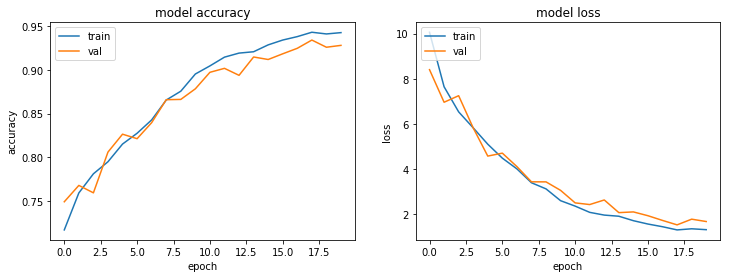

In [136]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(hist.history['acc'] + hist2.history['acc'])
ax[0].plot(hist.history['val_acc'] + hist2.history['val_acc'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
ax[1].plot(hist.history['loss'] + hist2.history['loss'])
ax[1].plot(hist.history['val_loss'] + hist2.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
fig.set_size_inches(12,4)
fig.show()

In [91]:
model.save('fcn_vgg16_20epochs')

RuntimeError: Unable to create link (name already exists)

In [107]:
mdl = tf.keras.models.load_model('fcn_vgg16_20epochs')

In [143]:
data, target = iter(val_ds).next()
predictions = mdl.predict(np.array(data))

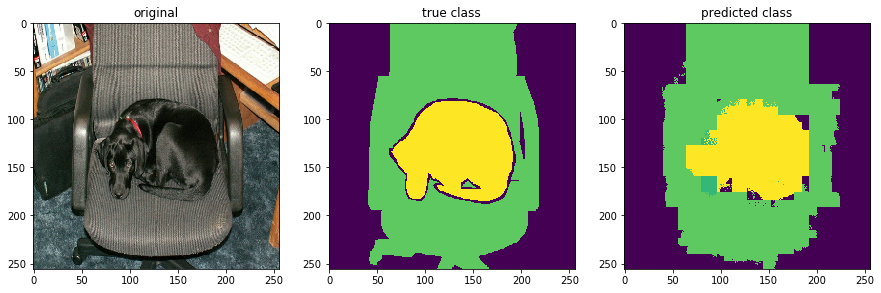

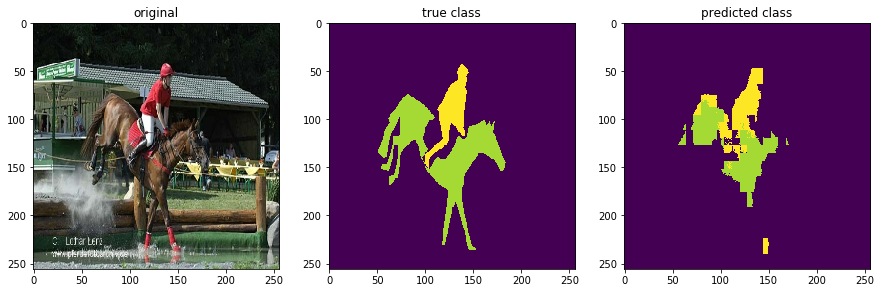

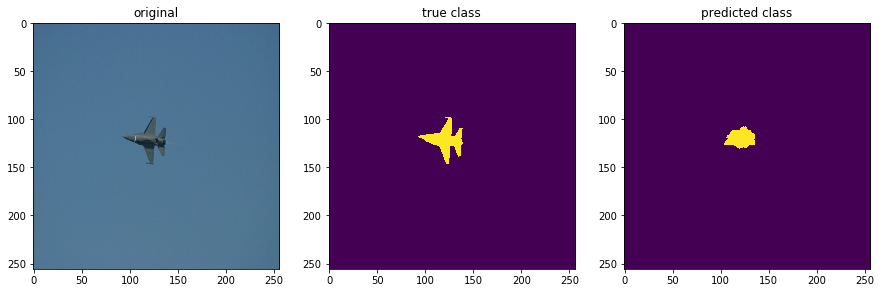

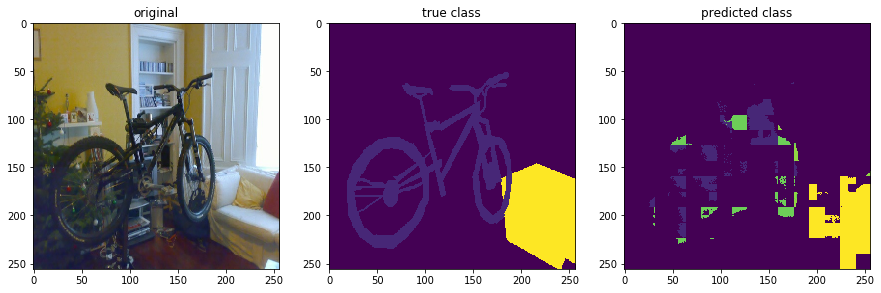

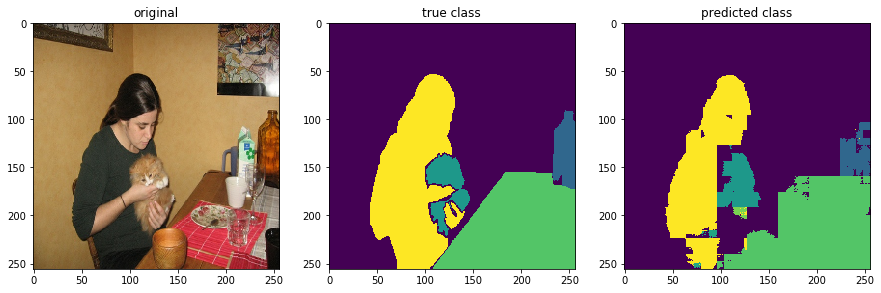

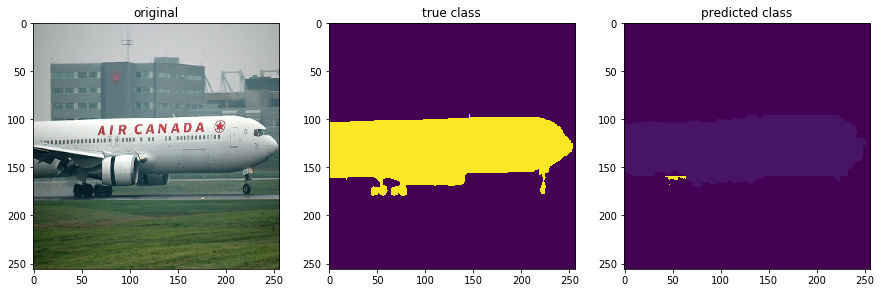

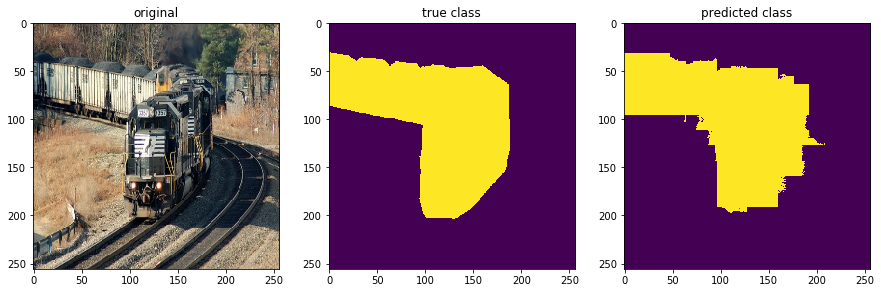

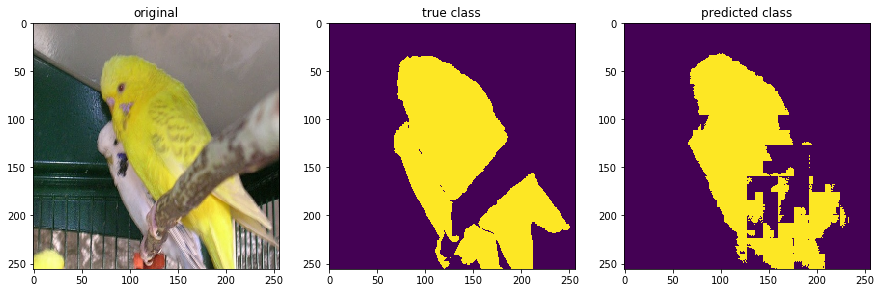

In [144]:
for i in range(8):
    fig = plt.figure(figsize=(15,30)) 
    ax = fig.add_subplot(1,3,1)
    ax.imshow(data[i])
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(np.argmax(target[i], axis=2))
    ax.set_title("true class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(np.argmax(predictions[i], axis=2))
    ax.set_title("predicted class")
    plt.show()